In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Анализ Логики

### Предобработка

In [2]:
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('data/positive.csv', sep=';', names=n, usecols=['text'])
data_negative = pd.read_csv('data/negative.csv', sep=';', names=n, usecols=['text'])
data_translated= pd.read_csv('data/translated.csv', sep=';',usecols=['text'])['text'].values
data_russian = np.concatenate((data_positive['text'].values[:20000],
                           data_negative['text'].values[:20000]), axis=0)#Поскольку датасет изначально русских текстов больше чем датасет берем первые 40000 его элементов

In [3]:
raw_data=np.concatenate((data_russian,data_translated),axis=0).astype(str)#Объединяем датасеты 
labels = [0] * len(data_russian)+[1]*len(data_translated)#Все переведенные фразы записываем в 'Нелогичные'(1) а те что изначально были на русском в логичные (0)

In [18]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    return text.strip()

In [5]:
data = [preprocess_text(t) for t in raw_data]#Предобработка текстов в датасете

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)#разбиение выборок на обучающую и тестовую

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

SENTENCE_LENGTH = 28
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

In [21]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load('./w2v/tweets_model.w2v')

DIM = w2v_model.vector_size 

In [86]:
embedding_matrix = np.zeros((NUM, DIM))
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.index_to_key:
        embedding_matrix[i] = w2v_model.wv[word]

In [10]:
embedding_matrix = np.load('embedding_matrix.np.npy') #S

In [89]:
np.save('embedding_matrix2.np', embedding_matrix) #L

In [2]:
from keras import backend as K


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [3]:
from keras.layers import Input
from tensorflow.keras.layers import Embedding
import tensorflow as tf

import keras
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D



### Модель

In [26]:
x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [14]:
tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)
branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

## Обучение на одном узле

In [15]:
model_L = Model(inputs=[tweet_input], outputs=[output])
model_L.compile(
      optimizer= keras.optimizers.SGD(learning_rate=0.1),#keras.optimizers.Adam(),
      loss='binary_crossentropy',
      metrics=[tf.keras.metrics.BinaryAccuracy(), precision, recall, f1]
  )

In [16]:
x_train_seq = np.array(x_train_seq)
y_train = np.array(y_train)

In [17]:
model_L.fit(x_train_seq, y_train, batch_size=32, epochs=20, validation_split=0.25)

Epoch 1/20
1500/1500 [==============================] - 369s 241ms/step - loss: 0.5049 - binary_accuracy: 0.7418 - precision: 0.7300 - recall: 0.7817 - f1: 0.7448 - val_loss: 0.3828 - val_binary_accuracy: 0.8320 - val_precision: 0.8044 - val_recall: 0.8683 - val_f1: 0.8313
Epoch 2/20
1500/1500 [==============================] - 498s 332ms/step - loss: 0.4015 - binary_accuracy: 0.8127 - precision: 0.7982 - recall: 0.8425 - f1: 0.8136 - val_loss: 0.3758 - val_binary_accuracy: 0.8149 - val_precision: 0.7431 - val_recall: 0.9519 - val_f1: 0.8310
Epoch 3/20
1500/1500 [==============================] - 512s 341ms/step - loss: 0.3704 - binary_accuracy: 0.8298 - precision: 0.8169 - recall: 0.8551 - f1: 0.8302 - val_loss: 0.3221 - val_binary_accuracy: 0.8591 - val_precision: 0.8482 - val_recall: 0.8686 - val_f1: 0.8545
Epoch 4/20
1500/1500 [==============================] - 608s 405ms/step - loss: 0.3484 - binary_accuracy: 0.8441 - precision: 0.8330 - recall: 0.8633 - f1: 0.8431 - val_loss: 0.3

## Обучение на 10 узлах

In [15]:
nodes = 10
logic = []

In [16]:
for i in range(nodes):
    logic.append(Model(inputs=[tweet_input], outputs=[output]))
    logic[i].compile(
        optimizer= keras.optimizers.SGD(learning_rate=0.1),#keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy(), precision, recall, f1],
)

In [17]:
x_train_split=np.array_split(x_train_seq, nodes)
y_train_split=np.array_split(y_train, nodes)

In [ ]:
import copy

for i in range(60):  #epocs
    print('epoch number', i+1)
    w = []
    for j in range(nodes): #models
        print('model number', j+1)
        logic[j].fit(x_train_split[j], y_train_split[j], batch_size=32, epochs=1, validation_split=0.25)
        w.append(copy.deepcopy(logic[j].get_weights()))
    for j in range(nodes): #обмен весами model
        weigth = copy.deepcopy(logic[j].get_weights())
        for h in range (len(w[0])):
            f1 = (j + 1)%nodes
            f2 = (j + 2)%nodes
            w[f1][h] += weigth[h]
            w[f2][h] += weigth[h]
    for j in range(nodes): 
        for h in range (len(w[0])):
            w[j][h] = w[j][h]/3
    for j in range(nodes):
        logic[j].set_weights(w[j])

epoch number 1
model number 1
150/150 [==============================] - 56s 323ms/step - loss: 0.7588 - binary_accuracy: 0.5462 - precision: 0.5402 - recall: 0.5704 - f1: 0.5330 - val_loss: 0.6267 - val_binary_accuracy: 0.5987 - val_precision: 0.5564 - val_recall: 0.7947 - val_f1: 0.6477
model number 2
150/150 [==============================] - 45s 184ms/step - loss: 0.5973 - binary_accuracy: 0.6545 - precision: 0.6481 - recall: 0.7165 - f1: 0.6678 - val_loss: 0.5403 - val_binary_accuracy: 0.7194 - val_precision: 0.6783 - val_recall: 0.8153 - val_f1: 0.7355
model number 3
150/150 [==============================] - 28s 80ms/step - loss: 0.5468 - binary_accuracy: 0.7006 - precision: 0.6929 - recall: 0.7370 - f1: 0.7030 - val_loss: 0.4825 - val_binary_accuracy: 0.7700 - val_precision: 0.7408 - val_recall: 0.8331 - val_f1: 0.7792
model number 4
150/150 [==============================] - 58s 295ms/step - loss: 0.5131 - binary_accuracy: 0.7420 - precision: 0.7313 - recall: 0.7870 - f1: 0.74

epoch number 4
model number 1
150/150 [==============================] - 33s 218ms/step - loss: 0.3708 - binary_accuracy: 0.8281 - precision: 0.8152 - recall: 0.8479 - f1: 0.8275 - val_loss: 0.3142 - val_binary_accuracy: 0.8650 - val_precision: 0.8370 - val_recall: 0.8930 - val_f1: 0.8603
model number 2
150/150 [==============================] - 14s 90ms/step - loss: 0.3596 - binary_accuracy: 0.8383 - precision: 0.8273 - recall: 0.8666 - f1: 0.8419 - val_loss: 0.3711 - val_binary_accuracy: 0.8200 - val_precision: 0.7542 - val_recall: 0.9415 - val_f1: 0.8340
model number 3
150/150 [==============================] - 55s 369ms/step - loss: 0.3556 - binary_accuracy: 0.8412 - precision: 0.8263 - recall: 0.8655 - f1: 0.8407 - val_loss: 0.3374 - val_binary_accuracy: 0.8494 - val_precision: 0.8137 - val_recall: 0.9082 - val_f1: 0.8525
model number 4
150/150 [==============================] - 49s 324ms/step - loss: 0.3529 - binary_accuracy: 0.8333 - precision: 0.8335 - recall: 0.8441 - f1: 0.83

epoch number 7
model number 1
150/150 [==============================] - 55s 366ms/step - loss: 0.3267 - binary_accuracy: 0.8548 - precision: 0.8454 - recall: 0.8697 - f1: 0.8525 - val_loss: 0.3023 - val_binary_accuracy: 0.8669 - val_precision: 0.8194 - val_recall: 0.9235 - val_f1: 0.8646
model number 2
150/150 [==============================] - 58s 387ms/step - loss: 0.3165 - binary_accuracy: 0.8610 - precision: 0.8602 - recall: 0.8687 - f1: 0.8596 - val_loss: 0.3478 - val_binary_accuracy: 0.8550 - val_precision: 0.7970 - val_recall: 0.9494 - val_f1: 0.8627
model number 3
150/150 [==============================] - 10s 65ms/step - loss: 0.3017 - binary_accuracy: 0.8681 - precision: 0.8621 - recall: 0.8806 - f1: 0.8673 - val_loss: 0.3232 - val_binary_accuracy: 0.8544 - val_precision: 0.8195 - val_recall: 0.9058 - val_f1: 0.8558
model number 4
150/150 [==============================] - 25s 165ms/step - loss: 0.3267 - binary_accuracy: 0.8556 - precision: 0.8510 - recall: 0.8679 - f1: 0.85

epoch number 10
model number 1
150/150 [==============================] - 29s 193ms/step - loss: 0.3023 - binary_accuracy: 0.8664 - precision: 0.8632 - recall: 0.8732 - f1: 0.8646 - val_loss: 0.2820 - val_binary_accuracy: 0.8850 - val_precision: 0.8599 - val_recall: 0.9048 - val_f1: 0.8782
model number 2
150/150 [==============================] - 36s 242ms/step - loss: 0.2951 - binary_accuracy: 0.8721 - precision: 0.8666 - recall: 0.8823 - f1: 0.8709 - val_loss: 0.2959 - val_binary_accuracy: 0.8675 - val_precision: 0.8365 - val_recall: 0.9057 - val_f1: 0.8664
model number 3
150/150 [==============================] - 8s 55ms/step - loss: 0.2857 - binary_accuracy: 0.8718 - precision: 0.8708 - recall: 0.8765 - f1: 0.8691 - val_loss: 0.2938 - val_binary_accuracy: 0.8694 - val_precision: 0.8378 - val_recall: 0.9122 - val_f1: 0.8696
model number 4
150/150 [==============================] - 54s 362ms/step - loss: 0.2914 - binary_accuracy: 0.8704 - precision: 0.8606 - recall: 0.8910 - f1: 0.87

epoch number 13
model number 1
150/150 [==============================] - 18s 117ms/step - loss: 0.2965 - binary_accuracy: 0.8764 - precision: 0.8693 - recall: 0.8879 - f1: 0.8751 - val_loss: 0.2694 - val_binary_accuracy: 0.8819 - val_precision: 0.8721 - val_recall: 0.8867 - val_f1: 0.8749
model number 2
150/150 [==============================] - 24s 162ms/step - loss: 0.2843 - binary_accuracy: 0.8773 - precision: 0.8764 - recall: 0.8836 - f1: 0.8753 - val_loss: 0.2899 - val_binary_accuracy: 0.8706 - val_precision: 0.8362 - val_recall: 0.9162 - val_f1: 0.8713
model number 3
150/150 [==============================] - 9s 55ms/step - loss: 0.2776 - binary_accuracy: 0.8804 - precision: 0.8792 - recall: 0.8845 - f1: 0.8774 - val_loss: 0.2964 - val_binary_accuracy: 0.8712 - val_precision: 0.8328 - val_recall: 0.9255 - val_f1: 0.8733
model number 4
150/150 [==============================] - 11s 68ms/step - loss: 0.2885 - binary_accuracy: 0.8791 - precision: 0.8742 - recall: 0.8863 - f1: 0.876

epoch number 16
model number 1
150/150 [==============================] - 20s 130ms/step - loss: 0.2799 - binary_accuracy: 0.8798 - precision: 0.8743 - recall: 0.8886 - f1: 0.8779 - val_loss: 0.2624 - val_binary_accuracy: 0.8888 - val_precision: 0.8694 - val_recall: 0.9050 - val_f1: 0.8826
model number 2
150/150 [==============================] - 19s 124ms/step - loss: 0.2720 - binary_accuracy: 0.8808 - precision: 0.8739 - recall: 0.8925 - f1: 0.8798 - val_loss: 0.2988 - val_binary_accuracy: 0.8644 - val_precision: 0.8263 - val_recall: 0.9206 - val_f1: 0.8671
model number 3
150/150 [==============================] - 10s 64ms/step - loss: 0.2530 - binary_accuracy: 0.8891 - precision: 0.8878 - recall: 0.8937 - f1: 0.8865 - val_loss: 0.2949 - val_binary_accuracy: 0.8694 - val_precision: 0.8312 - val_recall: 0.9257 - val_f1: 0.8727
model number 4
150/150 [==============================] - 15s 96ms/step - loss: 0.2748 - binary_accuracy: 0.8869 - precision: 0.8898 - recall: 0.8888 - f1: 0.88

epoch number 19
model number 1
150/150 [==============================] - 38s 251ms/step - loss: 0.2706 - binary_accuracy: 0.8841 - precision: 0.8776 - recall: 0.8914 - f1: 0.8814 - val_loss: 0.2701 - val_binary_accuracy: 0.8813 - val_precision: 0.8532 - val_recall: 0.9111 - val_f1: 0.8772
model number 2
150/150 [==============================] - 33s 218ms/step - loss: 0.2722 - binary_accuracy: 0.8864 - precision: 0.8823 - recall: 0.8954 - f1: 0.8842 - val_loss: 0.3163 - val_binary_accuracy: 0.8669 - val_precision: 0.8180 - val_recall: 0.9413 - val_f1: 0.8725
model number 3
150/150 [==============================] - 19s 125ms/step - loss: 0.2545 - binary_accuracy: 0.8908 - precision: 0.8871 - recall: 0.8967 - f1: 0.8882 - val_loss: 0.2880 - val_binary_accuracy: 0.8731 - val_precision: 0.8316 - val_recall: 0.9302 - val_f1: 0.8753
model number 4
150/150 [==============================] - 28s 187ms/step - loss: 0.2754 - binary_accuracy: 0.8791 - precision: 0.8780 - recall: 0.8874 - f1: 0.

epoch number 22
model number 1
150/150 [==============================] - 24s 160ms/step - loss: 0.2694 - binary_accuracy: 0.8833 - precision: 0.8763 - recall: 0.8913 - f1: 0.8799 - val_loss: 0.2682 - val_binary_accuracy: 0.8888 - val_precision: 0.8633 - val_recall: 0.9175 - val_f1: 0.8859
model number 2
150/150 [==============================] - 14s 90ms/step - loss: 0.2702 - binary_accuracy: 0.8800 - precision: 0.8732 - recall: 0.8945 - f1: 0.8797 - val_loss: 0.2965 - val_binary_accuracy: 0.8700 - val_precision: 0.8201 - val_recall: 0.9432 - val_f1: 0.8745
model number 3
150/150 [==============================] - 10s 69ms/step - loss: 0.2524 - binary_accuracy: 0.8923 - precision: 0.8888 - recall: 0.9009 - f1: 0.8913 - val_loss: 0.2913 - val_binary_accuracy: 0.8769 - val_precision: 0.8319 - val_recall: 0.9436 - val_f1: 0.8811
model number 4
150/150 [==============================] - 40s 268ms/step - loss: 0.2594 - binary_accuracy: 0.8925 - precision: 0.8910 - recall: 0.8989 - f1: 0.89

epoch number 25
model number 1
150/150 [==============================] - 14s 91ms/step - loss: 0.2578 - binary_accuracy: 0.8866 - precision: 0.8825 - recall: 0.8950 - f1: 0.8853 - val_loss: 0.2766 - val_binary_accuracy: 0.8913 - val_precision: 0.8480 - val_recall: 0.9403 - val_f1: 0.8886
model number 2
150/150 [==============================] - 10s 67ms/step - loss: 0.2598 - binary_accuracy: 0.8860 - precision: 0.8800 - recall: 0.8980 - f1: 0.8855 - val_loss: 0.2685 - val_binary_accuracy: 0.8856 - val_precision: 0.8570 - val_recall: 0.9224 - val_f1: 0.8856
model number 3
150/150 [==============================] - 5s 34ms/step - loss: 0.2439 - binary_accuracy: 0.8979 - precision: 0.8971 - recall: 0.9026 - f1: 0.8966 - val_loss: 0.2755 - val_binary_accuracy: 0.8813 - val_precision: 0.8448 - val_recall: 0.9307 - val_f1: 0.8831
model number 4
150/150 [==============================] - 52s 345ms/step - loss: 0.2569 - binary_accuracy: 0.8877 - precision: 0.8857 - recall: 0.8936 - f1: 0.8857

epoch number 28
model number 1
150/150 [==============================] - 11s 76ms/step - loss: 0.2585 - binary_accuracy: 0.8902 - precision: 0.8846 - recall: 0.9020 - f1: 0.8892 - val_loss: 0.2643 - val_binary_accuracy: 0.8913 - val_precision: 0.8589 - val_recall: 0.9237 - val_f1: 0.8867
model number 2
150/150 [==============================] - 51s 341ms/step - loss: 0.2592 - binary_accuracy: 0.8858 - precision: 0.8850 - recall: 0.8906 - f1: 0.8840 - val_loss: 0.2767 - val_binary_accuracy: 0.8825 - val_precision: 0.8565 - val_recall: 0.9203 - val_f1: 0.8839
model number 3
150/150 [==============================] - 6s 36ms/step - loss: 0.2352 - binary_accuracy: 0.9041 - precision: 0.9003 - recall: 0.9090 - f1: 0.9014 - val_loss: 0.2700 - val_binary_accuracy: 0.8844 - val_precision: 0.8568 - val_recall: 0.9193 - val_f1: 0.8843
model number 4
150/150 [==============================] - 23s 149ms/step - loss: 0.2556 - binary_accuracy: 0.8927 - precision: 0.8867 - recall: 0.8990 - f1: 0.889

epoch number 31
model number 1
150/150 [==============================] - 13s 85ms/step - loss: 0.2619 - binary_accuracy: 0.8873 - precision: 0.8808 - recall: 0.8976 - f1: 0.8848 - val_loss: 0.2624 - val_binary_accuracy: 0.8900 - val_precision: 0.8765 - val_recall: 0.8952 - val_f1: 0.8814
model number 2
150/150 [==============================] - 52s 346ms/step - loss: 0.2583 - binary_accuracy: 0.8946 - precision: 0.8901 - recall: 0.9048 - f1: 0.8946 - val_loss: 0.2887 - val_binary_accuracy: 0.8737 - val_precision: 0.8252 - val_recall: 0.9429 - val_f1: 0.8775
model number 3
150/150 [==============================] - 52s 350ms/step - loss: 0.2356 - binary_accuracy: 0.9046 - precision: 0.9029 - recall: 0.9087 - f1: 0.9031 - val_loss: 0.2649 - val_binary_accuracy: 0.8819 - val_precision: 0.8635 - val_recall: 0.9051 - val_f1: 0.8807
model number 4
150/150 [==============================] - 48s 317ms/step - loss: 0.2484 - binary_accuracy: 0.8933 - precision: 0.8850 - recall: 0.9075 - f1: 0.8

epoch number 34
model number 1
150/150 [==============================] - 15s 97ms/step - loss: 0.2465 - binary_accuracy: 0.8979 - precision: 0.8925 - recall: 0.9043 - f1: 0.8957 - val_loss: 0.2643 - val_binary_accuracy: 0.8831 - val_precision: 0.8581 - val_recall: 0.9015 - val_f1: 0.8752
model number 2
150/150 [==============================] - 14s 95ms/step - loss: 0.2488 - binary_accuracy: 0.8962 - precision: 0.8918 - recall: 0.9074 - f1: 0.8961 - val_loss: 0.2932 - val_binary_accuracy: 0.8775 - val_precision: 0.8398 - val_recall: 0.9308 - val_f1: 0.8795
model number 3
150/150 [==============================] - 8s 54ms/step - loss: 0.2291 - binary_accuracy: 0.9046 - precision: 0.8960 - recall: 0.9155 - f1: 0.9028 - val_loss: 0.2617 - val_binary_accuracy: 0.8838 - val_precision: 0.8639 - val_recall: 0.9097 - val_f1: 0.8831
model number 4
150/150 [==============================] - 49s 325ms/step - loss: 0.2489 - binary_accuracy: 0.8906 - precision: 0.8849 - recall: 0.9008 - f1: 0.8896

epoch number 37
model number 1
150/150 [==============================] - 15s 100ms/step - loss: 0.2535 - binary_accuracy: 0.8916 - precision: 0.8884 - recall: 0.8974 - f1: 0.8896 - val_loss: 0.2663 - val_binary_accuracy: 0.8900 - val_precision: 0.8553 - val_recall: 0.9265 - val_f1: 0.8858
model number 2
150/150 [==============================] - 14s 91ms/step - loss: 0.2446 - binary_accuracy: 0.8991 - precision: 0.8992 - recall: 0.9023 - f1: 0.8977 - val_loss: 0.2567 - val_binary_accuracy: 0.8888 - val_precision: 0.8659 - val_recall: 0.9171 - val_f1: 0.8877
model number 3
150/150 [==============================] - 8s 52ms/step - loss: 0.2296 - binary_accuracy: 0.9044 - precision: 0.9041 - recall: 0.9053 - f1: 0.9023 - val_loss: 0.2662 - val_binary_accuracy: 0.8838 - val_precision: 0.8486 - val_recall: 0.9303 - val_f1: 0.8848
model number 4
150/150 [==============================] - 10s 69ms/step - loss: 0.2506 - binary_accuracy: 0.8931 - precision: 0.8934 - recall: 0.8977 - f1: 0.8921

epoch number 40
model number 1
150/150 [==============================] - 48s 322ms/step - loss: 0.2430 - binary_accuracy: 0.8973 - precision: 0.8951 - recall: 0.9024 - f1: 0.8957 - val_loss: 0.2601 - val_binary_accuracy: 0.8906 - val_precision: 0.8672 - val_recall: 0.9100 - val_f1: 0.8841
model number 2
150/150 [==============================] - 11s 73ms/step - loss: 0.2321 - binary_accuracy: 0.9012 - precision: 0.8967 - recall: 0.9131 - f1: 0.9010 - val_loss: 0.2689 - val_binary_accuracy: 0.8856 - val_precision: 0.8541 - val_recall: 0.9272 - val_f1: 0.8863
model number 3
150/150 [==============================] - 24s 161ms/step - loss: 0.2323 - binary_accuracy: 0.9002 - precision: 0.8971 - recall: 0.9074 - f1: 0.8987 - val_loss: 0.2690 - val_binary_accuracy: 0.8856 - val_precision: 0.8507 - val_recall: 0.9305 - val_f1: 0.8863
model number 4
150/150 [==============================] - 48s 322ms/step - loss: 0.2254 - binary_accuracy: 0.9037 - precision: 0.9005 - recall: 0.9105 - f1: 0.9

## Проверка модели

График ниже показывает значение функции потерь на обучающей и валидационной выборке,поскольку они не расходятся можно сделать вывод, что переобучения не произошло

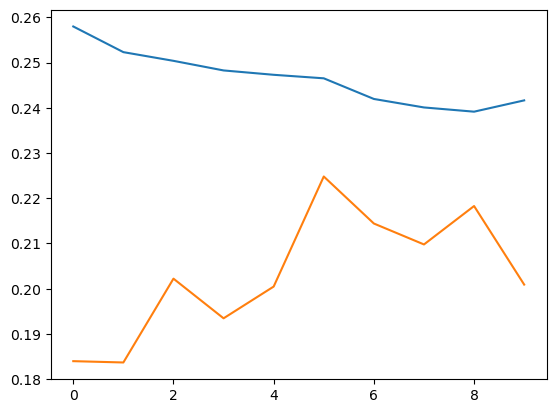

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [42]:
predicted1 = np.round(logic[1].predict(x_test_seq))
print(classification_report(y_test, predicted1, digits=6))

500/500 [==============================] - 3s 6ms/step
              precision    recall  f1-score   support

           0   0.908508  0.850356  0.878471      7999
           1   0.859342  0.914354  0.885995      7998

    accuracy                       0.882353     15997
   macro avg   0.883925  0.882355  0.882233     15997
weighted avg   0.883927  0.882353  0.882233     15997



In [18]:
predicted2 = np.round(model_L.predict(x_test_seq))
print(classification_report(y_test, predicted2, digits=6))

500/500 [==============================] - 4s 6ms/step
              precision    recall  f1-score   support

           0   0.919216  0.815102  0.864034      7999
           1   0.833895  0.928357  0.878594      7998

    accuracy                       0.871726     15997
   macro avg   0.876556  0.871729  0.871314     15997
weighted avg   0.876558  0.871726  0.871314     15997



# Анализ эмоций

### Предобработка

In [4]:
ekman_data=pd.read_csv('./data/ekman-translated.csv')

In [5]:
ekman_data = ekman_data.loc[(ekman_data['label'] == '0') | 
  (ekman_data['label'] == '1') | 
  (ekman_data['label'] == '2') |
  (ekman_data['label'] == '3') |
  (ekman_data['label'] == '4') | 
  (ekman_data['label'] == '5') | 
  (ekman_data['label'] == '6')]

In [6]:
ekman_data["label"].value_counts()

4    19020
0    16021
1     5420
6     4805
5     2875
3      693
2      635
Name: label, dtype: int64

In [7]:
dict1={'0':'нейтрально','1':'злость','2':'отвращение','3':'страх','4':'радость','5':'грусть','6':'удивление'}

In [8]:
ekman_data=ekman_data.replace({"label": dict1})

In [9]:
target_names = ['нейтрально', 'злость', 'отвращение', 'страх', 'радость', 'грусть', 'удивление']

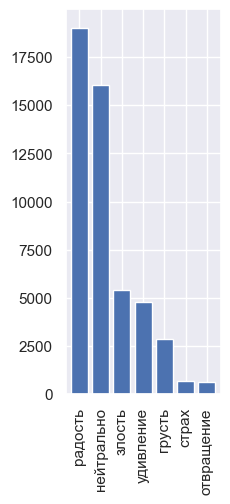

In [10]:
b=ekman_data["label"].value_counts()
import seaborn 
seaborn.set() 

df = pd.DataFrame(b.values, index=b.index)
df.plot(kind='bar', legend=False, width=0.8, figsize=(2,5))
plt.show()

In [11]:
def get_rat(data,samp,max_samp='joy'):
    
    return rat

In [12]:
def upsmple(data,samp,max_samp='joy'):
    rat = len(data.loc[data['label']==max_samp])//len(data.loc[data['label']==samp])
    df_1 = data.loc[data['label']==samp]
    df_1 = df_1.loc[df_1.index.repeat(rat)]
    train_n = pd.concat([data.loc[data['label']!=samp], df_1]).sample(frac=1)
    return train_n

In [13]:
ekman_data=upsmple(ekman_data,samp='страх',max_samp='радость')
ekman_data=upsmple(ekman_data,samp='злость',max_samp='радость')
ekman_data=upsmple(ekman_data,samp='удивление',max_samp='радость')
ekman_data=upsmple(ekman_data,samp='грусть',max_samp='радость')
ekman_data=upsmple(ekman_data,samp='отвращение',max_samp='радость')

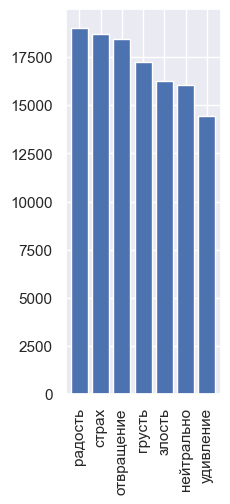

In [14]:
b=ekman_data["label"].value_counts()
import seaborn 
seaborn.set() 

df = pd.DataFrame(b.values, index=b.index)
df.plot(kind='bar', legend=False, width=0.8, figsize=(2,5))
plt.show()

In [15]:
x=ekman_data["text"].values.astype(str)
y=ekman_data.drop(['id','text','label'],axis=1).values

In [19]:
x = [preprocess_text(t) for t in x]

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

SENTENCE_LENGTH = 28
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

In [22]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load('./w2v/tweets_model.w2v')

DIM = w2v_model.vector_size 

In [23]:
embedding_matrix = np.load('embedding_matrix2.np.npy') #L

In [24]:
'''
model.compile(loss='binary_crossentropy', optimizer='adam', )
'''
from tensorflow.keras import activations
from tensorflow.keras.layers import Activation 
from tensorflow.keras.layers import BatchNormalization

    
tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)

x = tweet_encoder
branches = []
for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation=tf.keras.layers.LeakyReLU(alpha=0.01))(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1)

x = Dense(256)(x) 
x = BatchNormalization()(x) 
x = Activation('leaky_relu')(x)
x = Dropout(0.2)(x)

x = Dense(256)(x) 
x = BatchNormalization()(x) 
x = Activation('leaky_relu')(x)
x = Dropout(0.2)(x)

x = Dense(64)(x)
x = BatchNormalization()(x) 
x = Activation('leaky_relu')(x)
x = Dropout(0.2)(x)

x = Dense(7)(x)#7 выходных нейронов,по числу классов
output = Activation('softmax')(x)



### Обучение на одном узле

In [25]:
model_S = Model(inputs=[tweet_input], outputs=[output])
model_S.compile(
      optimizer= keras.optimizers.SGD(learning_rate=0.1),#keras.optimizers.Adam(),
      loss='categorical_crossentropy',
      metrics=[tf.keras.metrics.CategoricalAccuracy(), precision, recall, f1], 
  )

In [26]:
x_train_seq=get_sequences(tokenizer, x_train)
x_test_seq=get_sequences(tokenizer, x_test)

In [27]:
model_S.fit(x_train_seq, y_train, batch_size=256, epochs=40, validation_split=0.25)

Epoch 1/40
282/282 [==============================] - 274s 934ms/step - loss: 1.7228 - categorical_accuracy: 0.3222 - precision: 0.6369 - recall: 0.1037 - f1: 0.1724 - val_loss: 1.3862 - val_categorical_accuracy: 0.4626 - val_precision: 0.7795 - val_recall: 0.2746 - val_f1: 0.4055
Epoch 2/40
282/282 [==============================] - 258s 916ms/step - loss: 1.2017 - categorical_accuracy: 0.5280 - precision: 0.8605 - recall: 0.3313 - f1: 0.4773 - val_loss: 1.1401 - val_categorical_accuracy: 0.5528 - val_precision: 0.8284 - val_recall: 0.3864 - val_f1: 0.5264
Epoch 3/40
282/282 [==============================] - 268s 948ms/step - loss: 1.0256 - categorical_accuracy: 0.5938 - precision: 0.8845 - recall: 0.4081 - f1: 0.5580 - val_loss: 1.1298 - val_categorical_accuracy: 0.5756 - val_precision: 0.7988 - val_recall: 0.4225 - val_f1: 0.5522
Epoch 4/40
282/282 [==============================] - 248s 879ms/step - loss: 0.9399 - categorical_accuracy: 0.6259 - precision: 0.8817 - recall: 0.4535 -

Epoch 30/40
282/282 [==============================] - 259s 919ms/step - loss: 0.4919 - categorical_accuracy: 0.8078 - precision: 0.8801 - recall: 0.7375 - f1: 0.8024 - val_loss: 0.7257 - val_categorical_accuracy: 0.7455 - val_precision: 0.8225 - val_recall: 0.6791 - val_f1: 0.7438
Epoch 31/40
282/282 [==============================] - 262s 929ms/step - loss: 0.4887 - categorical_accuracy: 0.8094 - precision: 0.8816 - recall: 0.7408 - f1: 0.8050 - val_loss: 0.7471 - val_categorical_accuracy: 0.7476 - val_precision: 0.8198 - val_recall: 0.6864 - val_f1: 0.7471
Epoch 32/40
282/282 [==============================] - 255s 905ms/step - loss: 0.4826 - categorical_accuracy: 0.8129 - precision: 0.8812 - recall: 0.7451 - f1: 0.8073 - val_loss: 1.0261 - val_categorical_accuracy: 0.6636 - val_precision: 0.7427 - val_recall: 0.5940 - val_f1: 0.6599
Epoch 33/40
282/282 [==============================] - 251s 889ms/step - loss: 0.4807 - categorical_accuracy: 0.8119 - precision: 0.8819 - recall: 0.74

In [31]:
predicted1 = np.round(model_S.predict(x_test_seq))
print(classification_report(y_test, predicted1, zero_division = 0, digits=6))

751/751 [==============================] - 12s 16ms/step
              precision    recall  f1-score   support

           0   0.504923  0.111318  0.182419      3225
           1   0.635417  0.710389  0.670815      3263
           2   0.981385  0.984349  0.982865      3642
           3   0.976638  0.988315  0.982442      3680
           4   0.687880  0.572227  0.624746      3759
           5   0.887571  0.895667  0.891600      3508
           6   0.746744  0.526173  0.617348      2942

   micro avg   0.817542  0.696948  0.752444     24019
   macro avg   0.774365  0.684063  0.707462     24019
weighted avg   0.781308  0.696948  0.718787     24019
 samples avg   0.696948  0.696948  0.696948     24019



In [32]:
print("Evaluate on test data")
results = model_S.evaluate(x_test_seq, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
188/188 [==============================] - 7s 38ms/step - loss: 0.7303 - categorical_accuracy: 0.7534 - precision: 0.8176 - recall: 0.6970 - f1: 0.7523
test loss, test acc: [0.7302815318107605, 0.7533619403839111, 0.8176043033599854, 0.6970192790031433, 0.7522842884063721]


### Обучение на 10 узлах

In [28]:
nodes = 10
sentiment = []

In [29]:
for i in range(nodes):
    sentiment.append(Model(inputs=[tweet_input], outputs=[output]))
    sentiment[i].compile(
        optimizer= keras.optimizers.SGD(learning_rate=0.1),#keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=[tf.keras.metrics.CategoricalAccuracy(), precision, recall, f1], 
)

In [30]:
x_train_split=np.array_split(x_train_seq, nodes)
y_train_split=np.array_split(y_train, nodes)

In [31]:
import copy

for i in range(80):  #epocs
    print('epoch number', i+1)
    w = []
    for j in range(nodes): #models
        print('model number', j+1)
        sentiment[j].fit(x_train_split[j], y_train_split[j], batch_size=256, epochs=1, validation_split=0.25)
        w.append(copy.deepcopy(sentiment[j].get_weights()))
    for j in range(nodes): #обмен весами model
        weigth = copy.deepcopy(sentiment[j].get_weights())
        for h in range (len(w[0])):
            f1 = (j + 1)%nodes
            f2 = (j + 2)%nodes
            w[f1][h] += weigth[h]
            w[f2][h] += weigth[h]
    for j in range(nodes): 
        for h in range (len(w[0])):
            w[j][h] = w[j][h]/3
    for j in range(nodes):
        sentiment[j].set_weights(w[j])

epoch number 1
model number 1
29/29 [==============================] - 41s 1s/step - loss: 2.1158 - categorical_accuracy: 0.1757 - precision: 0.2256 - recall: 0.0176 - f1: 0.0322 - val_loss: 2.0343 - val_categorical_accuracy: 0.1873 - val_precision: 0.3483 - val_recall: 0.0047 - val_f1: 0.0092
model number 2
29/29 [==============================] - 57s 1s/step - loss: 1.9807 - categorical_accuracy: 0.2051 - precision: 0.3403 - recall: 0.0164 - f1: 0.0312 - val_loss: 1.9233 - val_categorical_accuracy: 0.2298 - val_precision: 0.1000 - val_recall: 7.8125e-04 - val_f1: 0.0016
model number 3
29/29 [==============================] - 44s 1s/step - loss: 1.8973 - categorical_accuracy: 0.2383 - precision: 0.5045 - recall: 0.0253 - f1: 0.0479 - val_loss: 1.8677 - val_categorical_accuracy: 0.2435 - val_precision: 0.7338 - val_recall: 0.0241 - val_f1: 0.0464
model number 4
29/29 [==============================] - 40s 1s/step - loss: 1.8092 - categorical_accuracy: 0.2898 - precision: 0.6100 - recal

model number 10
29/29 [==============================] - 27s 929ms/step - loss: 0.9856 - categorical_accuracy: 0.6146 - precision: 0.8698 - recall: 0.4415 - f1: 0.5853 - val_loss: 1.2323 - val_categorical_accuracy: 0.5662 - val_precision: 0.7349 - val_recall: 0.4402 - val_f1: 0.5502
epoch number 4
model number 1
29/29 [==============================] - 28s 947ms/step - loss: 0.9759 - categorical_accuracy: 0.6149 - precision: 0.8660 - recall: 0.4521 - f1: 0.5935 - val_loss: 1.0054 - val_categorical_accuracy: 0.6095 - val_precision: 0.8297 - val_recall: 0.4622 - val_f1: 0.5933
model number 2
29/29 [==============================] - 28s 980ms/step - loss: 0.9523 - categorical_accuracy: 0.6286 - precision: 0.8817 - recall: 0.4617 - f1: 0.6057 - val_loss: 0.9969 - val_categorical_accuracy: 0.6266 - val_precision: 0.8109 - val_recall: 0.4750 - val_f1: 0.5987
model number 3
29/29 [==============================] - 32s 1s/step - loss: 0.9526 - categorical_accuracy: 0.6270 - precision: 0.8701 -

model number 9
29/29 [==============================] - 35s 1s/step - loss: 0.8295 - categorical_accuracy: 0.6819 - precision: 0.8673 - recall: 0.5263 - f1: 0.6548 - val_loss: 1.0242 - val_categorical_accuracy: 0.6128 - val_precision: 0.7911 - val_recall: 0.4837 - val_f1: 0.5999
model number 10
29/29 [==============================] - 38s 1s/step - loss: 0.8508 - categorical_accuracy: 0.6698 - precision: 0.8530 - recall: 0.5191 - f1: 0.6451 - val_loss: 1.6335 - val_categorical_accuracy: 0.5146 - val_precision: 0.7527 - val_recall: 0.3654 - val_f1: 0.4913
epoch number 7
model number 1
29/29 [==============================] - 30s 1s/step - loss: 0.8410 - categorical_accuracy: 0.6762 - precision: 0.8749 - recall: 0.5293 - f1: 0.6593 - val_loss: 0.9521 - val_categorical_accuracy: 0.6420 - val_precision: 0.8018 - val_recall: 0.5351 - val_f1: 0.6416
model number 2
29/29 [==============================] - 33s 1s/step - loss: 0.8113 - categorical_accuracy: 0.6812 - precision: 0.8743 - recall: 

model number 8
29/29 [==============================] - 29s 991ms/step - loss: 0.7328 - categorical_accuracy: 0.7169 - precision: 0.8696 - recall: 0.5801 - f1: 0.6954 - val_loss: 0.8101 - val_categorical_accuracy: 0.6848 - val_precision: 0.8192 - val_recall: 0.5775 - val_f1: 0.6772
model number 9
29/29 [==============================] - 33s 1s/step - loss: 0.7367 - categorical_accuracy: 0.7169 - precision: 0.8684 - recall: 0.5869 - f1: 0.7003 - val_loss: 1.4885 - val_categorical_accuracy: 0.5587 - val_precision: 0.6533 - val_recall: 0.4638 - val_f1: 0.5423
model number 10
29/29 [==============================] - 33s 1s/step - loss: 0.7468 - categorical_accuracy: 0.7144 - precision: 0.8707 - recall: 0.5766 - f1: 0.6935 - val_loss: 1.0936 - val_categorical_accuracy: 0.6211 - val_precision: 0.7505 - val_recall: 0.5249 - val_f1: 0.6176
epoch number 10
model number 1
29/29 [==============================] - 31s 1s/step - loss: 0.7502 - categorical_accuracy: 0.7118 - precision: 0.8641 - reca

29/29 [==============================] - 31s 1s/step - loss: 0.6889 - categorical_accuracy: 0.7342 - precision: 0.8700 - recall: 0.6053 - f1: 0.7135 - val_loss: 0.8231 - val_categorical_accuracy: 0.6923 - val_precision: 0.8418 - val_recall: 0.5846 - val_f1: 0.6898
model number 8
29/29 [==============================] - 31s 1s/step - loss: 0.6816 - categorical_accuracy: 0.7392 - precision: 0.8714 - recall: 0.6203 - f1: 0.7245 - val_loss: 0.8470 - val_categorical_accuracy: 0.6915 - val_precision: 0.8071 - val_recall: 0.6035 - val_f1: 0.6904
model number 9
29/29 [==============================] - 28s 957ms/step - loss: 0.6701 - categorical_accuracy: 0.7442 - precision: 0.8763 - recall: 0.6303 - f1: 0.7330 - val_loss: 0.9094 - val_categorical_accuracy: 0.6611 - val_precision: 0.7901 - val_recall: 0.5739 - val_f1: 0.6647
model number 10
29/29 [==============================] - 29s 992ms/step - loss: 0.6828 - categorical_accuracy: 0.7375 - precision: 0.8568 - recall: 0.6263 - f1: 0.7233 - va

model number 6
29/29 [==============================] - 29s 980ms/step - loss: 0.6305 - categorical_accuracy: 0.7560 - precision: 0.8798 - recall: 0.6572 - f1: 0.7521 - val_loss: 0.8049 - val_categorical_accuracy: 0.7044 - val_precision: 0.8198 - val_recall: 0.6034 - val_f1: 0.6949
model number 7
29/29 [==============================] - 29s 1s/step - loss: 0.6309 - categorical_accuracy: 0.7573 - precision: 0.8719 - recall: 0.6553 - f1: 0.7478 - val_loss: 0.9415 - val_categorical_accuracy: 0.6515 - val_precision: 0.8006 - val_recall: 0.5484 - val_f1: 0.6507
model number 8
29/29 [==============================] - 38s 1s/step - loss: 0.6407 - categorical_accuracy: 0.7523 - precision: 0.8728 - recall: 0.6446 - f1: 0.7414 - val_loss: 0.9086 - val_categorical_accuracy: 0.6811 - val_precision: 0.7787 - val_recall: 0.6177 - val_f1: 0.6888
model number 9
29/29 [==============================] - 28s 973ms/step - loss: 0.6269 - categorical_accuracy: 0.7621 - precision: 0.8731 - recall: 0.6580 - f

model number 5
29/29 [==============================] - 28s 951ms/step - loss: 0.5848 - categorical_accuracy: 0.7720 - precision: 0.8745 - recall: 0.6844 - f1: 0.7677 - val_loss: 1.0733 - val_categorical_accuracy: 0.6520 - val_precision: 0.7353 - val_recall: 0.5704 - val_f1: 0.6423
model number 6
29/29 [==============================] - 31s 1s/step - loss: 0.6172 - categorical_accuracy: 0.7582 - precision: 0.8715 - recall: 0.6626 - f1: 0.7526 - val_loss: 0.8318 - val_categorical_accuracy: 0.6815 - val_precision: 0.8134 - val_recall: 0.5869 - val_f1: 0.6816
model number 7
29/29 [==============================] - 30s 1s/step - loss: 0.5987 - categorical_accuracy: 0.7634 - precision: 0.8787 - recall: 0.6651 - f1: 0.7569 - val_loss: 0.9912 - val_categorical_accuracy: 0.6499 - val_precision: 0.7796 - val_recall: 0.5432 - val_f1: 0.6400
model number 8
29/29 [==============================] - 29s 1s/step - loss: 0.6027 - categorical_accuracy: 0.7663 - precision: 0.8779 - recall: 0.6689 - f1: 

model number 4
29/29 [==============================] - 28s 971ms/step - loss: 0.5712 - categorical_accuracy: 0.7853 - precision: 0.8780 - recall: 0.6862 - f1: 0.7701 - val_loss: 0.7710 - val_categorical_accuracy: 0.7211 - val_precision: 0.8218 - val_recall: 0.6472 - val_f1: 0.7240
model number 5
29/29 [==============================] - 28s 964ms/step - loss: 0.5574 - categorical_accuracy: 0.7851 - precision: 0.8762 - recall: 0.7043 - f1: 0.7807 - val_loss: 0.8245 - val_categorical_accuracy: 0.7094 - val_precision: 0.7947 - val_recall: 0.6349 - val_f1: 0.7058
model number 6
29/29 [==============================] - 27s 934ms/step - loss: 0.5583 - categorical_accuracy: 0.7803 - precision: 0.8762 - recall: 0.6874 - f1: 0.7702 - val_loss: 1.6144 - val_categorical_accuracy: 0.5375 - val_precision: 0.6566 - val_recall: 0.4497 - val_f1: 0.5335
model number 7
29/29 [==============================] - 28s 954ms/step - loss: 0.6004 - categorical_accuracy: 0.7664 - precision: 0.8688 - recall: 0.67

model number 3
29/29 [==============================] - 30s 1s/step - loss: 0.5595 - categorical_accuracy: 0.7852 - precision: 0.8683 - recall: 0.6990 - f1: 0.7743 - val_loss: 0.7429 - val_categorical_accuracy: 0.7327 - val_precision: 0.8159 - val_recall: 0.6520 - val_f1: 0.7246
model number 4
29/29 [==============================] - 38s 1s/step - loss: 0.5405 - categorical_accuracy: 0.7946 - precision: 0.8736 - recall: 0.7091 - f1: 0.7825 - val_loss: 1.8406 - val_categorical_accuracy: 0.6141 - val_precision: 0.6558 - val_recall: 0.5580 - val_f1: 0.6027
model number 5
29/29 [==============================] - 30s 1s/step - loss: 0.5502 - categorical_accuracy: 0.7882 - precision: 0.8793 - recall: 0.7035 - f1: 0.7813 - val_loss: 0.7952 - val_categorical_accuracy: 0.7277 - val_precision: 0.8105 - val_recall: 0.6579 - val_f1: 0.7261
model number 6
29/29 [==============================] - 34s 1s/step - loss: 0.5452 - categorical_accuracy: 0.7886 - precision: 0.8786 - recall: 0.7036 - f1: 0.7

29/29 [==============================] - 29s 1s/step - loss: 0.5181 - categorical_accuracy: 0.8007 - precision: 0.8848 - recall: 0.7228 - f1: 0.7955 - val_loss: 0.7552 - val_categorical_accuracy: 0.7365 - val_precision: 0.8186 - val_recall: 0.6638 - val_f1: 0.7330
model number 3
29/29 [==============================] - 34s 1s/step - loss: 0.5331 - categorical_accuracy: 0.7889 - precision: 0.8744 - recall: 0.7127 - f1: 0.7852 - val_loss: 0.7581 - val_categorical_accuracy: 0.7256 - val_precision: 0.8056 - val_recall: 0.6618 - val_f1: 0.7264
model number 4
29/29 [==============================] - 36s 1s/step - loss: 0.5183 - categorical_accuracy: 0.8014 - precision: 0.8786 - recall: 0.7275 - f1: 0.7958 - val_loss: 0.7890 - val_categorical_accuracy: 0.7277 - val_precision: 0.8016 - val_recall: 0.6670 - val_f1: 0.7280
model number 5
29/29 [==============================] - 32s 1s/step - loss: 0.5106 - categorical_accuracy: 0.8047 - precision: 0.8721 - recall: 0.7306 - f1: 0.7950 - val_loss:

29/29 [==============================] - 30s 1s/step - loss: 0.4982 - categorical_accuracy: 0.8053 - precision: 0.8777 - recall: 0.7424 - f1: 0.8042 - val_loss: 0.9122 - val_categorical_accuracy: 0.6994 - val_precision: 0.7692 - val_recall: 0.6501 - val_f1: 0.7045
epoch number 33
model number 1
29/29 [==============================] - 30s 1s/step - loss: 0.4946 - categorical_accuracy: 0.8077 - precision: 0.8767 - recall: 0.7371 - f1: 0.8006 - val_loss: 0.8751 - val_categorical_accuracy: 0.7319 - val_precision: 0.7785 - val_recall: 0.6739 - val_f1: 0.7223
model number 2
29/29 [==============================] - 31s 1s/step - loss: 0.4952 - categorical_accuracy: 0.8074 - precision: 0.8816 - recall: 0.7423 - f1: 0.8058 - val_loss: 0.8022 - val_categorical_accuracy: 0.7144 - val_precision: 0.7899 - val_recall: 0.6571 - val_f1: 0.7172
model number 3
29/29 [==============================] - 34s 1s/step - loss: 0.4871 - categorical_accuracy: 0.8104 - precision: 0.8774 - recall: 0.7416 - f1: 0.

29/29 [==============================] - 31s 1s/step - loss: 0.4705 - categorical_accuracy: 0.8112 - precision: 0.8749 - recall: 0.7467 - f1: 0.8055 - val_loss: 0.8862 - val_categorical_accuracy: 0.7148 - val_precision: 0.7803 - val_recall: 0.6702 - val_f1: 0.7210
model number 9
29/29 [==============================] - 29s 1s/step - loss: 0.4642 - categorical_accuracy: 0.8218 - precision: 0.8808 - recall: 0.7648 - f1: 0.8185 - val_loss: 0.7884 - val_categorical_accuracy: 0.7448 - val_precision: 0.8056 - val_recall: 0.6871 - val_f1: 0.7413
model number 10
29/29 [==============================] - 29s 985ms/step - loss: 0.4581 - categorical_accuracy: 0.8260 - precision: 0.8829 - recall: 0.7671 - f1: 0.8208 - val_loss: 0.9851 - val_categorical_accuracy: 0.7044 - val_precision: 0.7623 - val_recall: 0.6542 - val_f1: 0.7040
epoch number 39
model number 1
29/29 [==============================] - 30s 1s/step - loss: 0.4648 - categorical_accuracy: 0.8203 - precision: 0.8798 - recall: 0.7691 - f1

29/29 [==============================] - 30s 1s/step - loss: 0.4561 - categorical_accuracy: 0.8236 - precision: 0.8840 - recall: 0.7679 - f1: 0.8218 - val_loss: 0.7975 - val_categorical_accuracy: 0.7390 - val_precision: 0.7933 - val_recall: 0.7058 - val_f1: 0.7469
model number 7
29/29 [==============================] - 29s 1s/step - loss: 0.4486 - categorical_accuracy: 0.8228 - precision: 0.8841 - recall: 0.7747 - f1: 0.8257 - val_loss: 1.0412 - val_categorical_accuracy: 0.6778 - val_precision: 0.7590 - val_recall: 0.6301 - val_f1: 0.6884
model number 8
29/29 [==============================] - 31s 1s/step - loss: 0.4445 - categorical_accuracy: 0.8303 - precision: 0.8847 - recall: 0.7695 - f1: 0.8230 - val_loss: 1.0276 - val_categorical_accuracy: 0.7140 - val_precision: 0.7689 - val_recall: 0.6763 - val_f1: 0.7195
model number 9
29/29 [==============================] - 29s 995ms/step - loss: 0.4365 - categorical_accuracy: 0.8329 - precision: 0.8820 - recall: 0.7704 - f1: 0.8224 - val_lo

29/29 [==============================] - 31s 1s/step - loss: 0.4082 - categorical_accuracy: 0.8451 - precision: 0.8861 - recall: 0.7924 - f1: 0.8366 - val_loss: 1.6936 - val_categorical_accuracy: 0.6037 - val_precision: 0.6587 - val_recall: 0.5545 - val_f1: 0.6019
model number 5
29/29 [==============================] - 28s 961ms/step - loss: 0.4334 - categorical_accuracy: 0.8341 - precision: 0.8840 - recall: 0.7864 - f1: 0.8323 - val_loss: 0.9661 - val_categorical_accuracy: 0.7390 - val_precision: 0.7834 - val_recall: 0.6926 - val_f1: 0.7351
model number 6
29/29 [==============================] - 31s 1s/step - loss: 0.4332 - categorical_accuracy: 0.8340 - precision: 0.8833 - recall: 0.7835 - f1: 0.8303 - val_loss: 0.8840 - val_categorical_accuracy: 0.7077 - val_precision: 0.7628 - val_recall: 0.6703 - val_f1: 0.7134
model number 7
29/29 [==============================] - 36s 1s/step - loss: 0.4390 - categorical_accuracy: 0.8279 - precision: 0.8802 - recall: 0.7798 - f1: 0.8266 - val_lo

29/29 [==============================] - 35s 1s/step - loss: 0.4065 - categorical_accuracy: 0.8376 - precision: 0.8822 - recall: 0.7904 - f1: 0.8336 - val_loss: 0.9647 - val_categorical_accuracy: 0.7298 - val_precision: 0.7727 - val_recall: 0.6827 - val_f1: 0.7248
model number 3
29/29 [==============================] - 31s 1s/step - loss: 0.4081 - categorical_accuracy: 0.8374 - precision: 0.8863 - recall: 0.7988 - f1: 0.8402 - val_loss: 0.6753 - val_categorical_accuracy: 0.7785 - val_precision: 0.8174 - val_recall: 0.7368 - val_f1: 0.7749
model number 4
29/29 [==============================] - 28s 969ms/step - loss: 0.3883 - categorical_accuracy: 0.8508 - precision: 0.8912 - recall: 0.8071 - f1: 0.8470 - val_loss: 0.8348 - val_categorical_accuracy: 0.7485 - val_precision: 0.7908 - val_recall: 0.7145 - val_f1: 0.7506
model number 5
29/29 [==============================] - 30s 1s/step - loss: 0.3838 - categorical_accuracy: 0.8495 - precision: 0.8902 - recall: 0.8071 - f1: 0.8465 - val_lo

epoch number 59
model number 1
29/29 [==============================] - 28s 972ms/step - loss: 0.3883 - categorical_accuracy: 0.8472 - precision: 0.8883 - recall: 0.8047 - f1: 0.8443 - val_loss: 1.3151 - val_categorical_accuracy: 0.6415 - val_precision: 0.6932 - val_recall: 0.6059 - val_f1: 0.6466
model number 2
29/29 [==============================] - 30s 1s/step - loss: 0.4196 - categorical_accuracy: 0.8418 - precision: 0.8866 - recall: 0.7971 - f1: 0.8394 - val_loss: 0.8433 - val_categorical_accuracy: 0.7490 - val_precision: 0.7880 - val_recall: 0.6999 - val_f1: 0.7413
model number 3
29/29 [==============================] - 39s 1s/step - loss: 0.4099 - categorical_accuracy: 0.8426 - precision: 0.8865 - recall: 0.8001 - f1: 0.8410 - val_loss: 0.8321 - val_categorical_accuracy: 0.7498 - val_precision: 0.7935 - val_recall: 0.7124 - val_f1: 0.7506
model number 4
29/29 [==============================] - 32s 1s/step - loss: 0.3847 - categorical_accuracy: 0.8505 - precision: 0.8879 - recal

29/29 [==============================] - 35s 1s/step - loss: 0.3750 - categorical_accuracy: 0.8575 - precision: 0.8974 - recall: 0.8172 - f1: 0.8553 - val_loss: 0.7064 - val_categorical_accuracy: 0.7664 - val_precision: 0.8048 - val_recall: 0.7287 - val_f1: 0.7648
epoch number 62
model number 1
29/29 [==============================] - 31s 1s/step - loss: 0.3739 - categorical_accuracy: 0.8525 - precision: 0.8932 - recall: 0.8168 - f1: 0.8532 - val_loss: 0.7608 - val_categorical_accuracy: 0.7669 - val_precision: 0.8069 - val_recall: 0.7282 - val_f1: 0.7654
model number 2
29/29 [==============================] - 30s 1s/step - loss: 0.3811 - categorical_accuracy: 0.8530 - precision: 0.8912 - recall: 0.8144 - f1: 0.8511 - val_loss: 1.1092 - val_categorical_accuracy: 0.7127 - val_precision: 0.7483 - val_recall: 0.6699 - val_f1: 0.7068
model number 3
29/29 [==============================] - 32s 1s/step - loss: 0.3837 - categorical_accuracy: 0.8558 - precision: 0.8995 - recall: 0.8123 - f1: 0.

29/29 [==============================] - 30s 1s/step - loss: 0.3759 - categorical_accuracy: 0.8512 - precision: 0.8865 - recall: 0.8150 - f1: 0.8491 - val_loss: 0.8355 - val_categorical_accuracy: 0.7469 - val_precision: 0.7855 - val_recall: 0.7183 - val_f1: 0.7504
model number 9
29/29 [==============================] - 32s 1s/step - loss: 0.3751 - categorical_accuracy: 0.8591 - precision: 0.8910 - recall: 0.8221 - f1: 0.8551 - val_loss: 0.8726 - val_categorical_accuracy: 0.7352 - val_precision: 0.7745 - val_recall: 0.6922 - val_f1: 0.7309
model number 10
29/29 [==============================] - 31s 1s/step - loss: 0.3846 - categorical_accuracy: 0.8541 - precision: 0.8894 - recall: 0.8162 - f1: 0.8511 - val_loss: 1.1287 - val_categorical_accuracy: 0.6894 - val_precision: 0.7249 - val_recall: 0.6629 - val_f1: 0.6924
epoch number 68
model number 1
29/29 [==============================] - 32s 1s/step - loss: 0.3700 - categorical_accuracy: 0.8598 - precision: 0.8942 - recall: 0.8195 - f1: 0

29/29 [==============================] - 32s 1s/step - loss: 0.3504 - categorical_accuracy: 0.8629 - precision: 0.8994 - recall: 0.8310 - f1: 0.8638 - val_loss: 0.7867 - val_categorical_accuracy: 0.7748 - val_precision: 0.8091 - val_recall: 0.7537 - val_f1: 0.7803
model number 7
29/29 [==============================] - 31s 1s/step - loss: 0.3498 - categorical_accuracy: 0.8645 - precision: 0.9003 - recall: 0.8314 - f1: 0.8644 - val_loss: 1.0660 - val_categorical_accuracy: 0.7061 - val_precision: 0.7468 - val_recall: 0.6649 - val_f1: 0.7033
model number 8
29/29 [==============================] - 31s 1s/step - loss: 0.3593 - categorical_accuracy: 0.8586 - precision: 0.8950 - recall: 0.8264 - f1: 0.8592 - val_loss: 0.7284 - val_categorical_accuracy: 0.7818 - val_precision: 0.8124 - val_recall: 0.7644 - val_f1: 0.7876
model number 9
29/29 [==============================] - 29s 1s/step - loss: 0.3628 - categorical_accuracy: 0.8611 - precision: 0.8921 - recall: 0.8242 - f1: 0.8567 - val_loss:

29/29 [==============================] - 31s 1s/step - loss: 0.3284 - categorical_accuracy: 0.8726 - precision: 0.9037 - recall: 0.8397 - f1: 0.8703 - val_loss: 0.9950 - val_categorical_accuracy: 0.7456 - val_precision: 0.7758 - val_recall: 0.7190 - val_f1: 0.7463
model number 5
29/29 [==============================] - 30s 1s/step - loss: 0.3547 - categorical_accuracy: 0.8605 - precision: 0.8892 - recall: 0.8304 - f1: 0.8587 - val_loss: 0.8771 - val_categorical_accuracy: 0.7739 - val_precision: 0.8020 - val_recall: 0.7503 - val_f1: 0.7752
model number 6
29/29 [==============================] - 30s 1s/step - loss: 0.3339 - categorical_accuracy: 0.8672 - precision: 0.8992 - recall: 0.8332 - f1: 0.8648 - val_loss: 1.1083 - val_categorical_accuracy: 0.7273 - val_precision: 0.7696 - val_recall: 0.7065 - val_f1: 0.7366
model number 7
29/29 [==============================] - 31s 1s/step - loss: 0.3590 - categorical_accuracy: 0.8594 - precision: 0.8921 - recall: 0.8295 - f1: 0.8596 - val_loss:

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [60]:
print("Evaluate on test data")
results = sentiment[0].evaluate(x_test_seq, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
188/188 [==============================] - 4s 19ms/step - loss: 0.8253 - categorical_accuracy: 0.7660 - precision: 0.8011 - recall: 0.7382 - f1: 0.7682
test loss, test acc: [0.8253052830696106, 0.7660185694694519, 0.8010857105255127, 0.7381646037101746, 0.7681997418403625]


In [53]:
predicted = np.round(sentiment[3].predict(x_test_seq))
print(classification_report(y_test, predicted, zero_division = 0, digits=6))

751/751 [==============================] - 6s 8ms/step
              precision    recall  f1-score   support

           0   0.428507  0.298742  0.352047      3180
           1   0.774949  0.561607  0.651251      3360
           2   0.969853  0.989745  0.979698      3608
           3   0.957386  0.998092  0.977315      3669
           4   0.681661  0.615946  0.647139      3838
           5   0.874436  0.952849  0.911960      3457
           6   0.732215  0.690402  0.710694      2907

   micro avg   0.801220  0.738374  0.768514     24019
   macro avg   0.774144  0.729626  0.747158     24019
weighted avg   0.780467  0.738374  0.754844     24019
 samples avg   0.738374  0.738374  0.738374     24019



# Отбор текста для проекта

In [47]:
def prepareText(text,tokenizer):
    text_seq = get_sequences(tokenizer, [text])
    return text_seq,text

In [295]:
fullTexts = []

In [296]:
f = open('./data/FullDataset.txt', encoding='utf-8')

for line in f:
    fullTexts.append([line])
fullTexts

[['\ufeffНейросети применяются в области компьютерного зрения для распознавания и классификации изображений.\n'],
 ['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n'],
 ['В области естественного языка нейросети используются для автоматического перевода и анализа текстов.\n'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n'],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n'],
 ['Нейросети применяются в игровой индустрии для создания умных и реалистичных виртуальных персонажей.\n'],

In [297]:
length = len(fullTexts)

In [298]:
for i in range(length):
    text_seq, text = prepareText(fullTexts[i][0], tokenizer)
    fullTexts[i].append(model_L.predict(text_seq)[0][0])
fullTexts

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


[['\ufeffНейросети применяются в области компьютерного зрения для распознавания и классификации изображений.\n',
  0.11255009],
 ['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776],
 ['В области естественного языка нейросети используются для автоматического перевода и анализа текстов.\n',
  0.38888586],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135]

In [299]:
preFinalTexts = []

In [300]:
k = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(length):
    if (fullTexts[i][1] >= 0 and fullTexts[i][1] < 0.1):
        k[0] += 1
    if (fullTexts[i][1] >= 0.1 and fullTexts[i][1] < 0.2):
        k[1] += 1
    if (fullTexts[i][1] >= 0.2 and fullTexts[i][1] < 0.3):
        k[2] += 1
    if (fullTexts[i][1] >= 0.3 and fullTexts[i][1] < 0.4):
        k[3] += 1
    if (fullTexts[i][1] >= 0.4 and fullTexts[i][1] < 0.5):
        k[4] += 1
    if (fullTexts[i][1] >= 0.5 and fullTexts[i][1] < 0.6):
        k[5] += 1
    if (fullTexts[i][1] >= 0.6 and fullTexts[i][1] < 0.7):
        preFinalTexts.append(fullTexts[i])
        k[6] += 1
    if (fullTexts[i][1] >= 0.7 and fullTexts[i][1] < 0.8):
        preFinalTexts.append(fullTexts[i])
        k[7] += 1
    if (fullTexts[i][1] >= 0.8 and fullTexts[i][1] < 0.9):
        preFinalTexts.append(fullTexts[i])
        k[8] += 1
    if (fullTexts[i][1] >= 0.9 and fullTexts[i][1] <= 1):
        preFinalTexts.append(fullTexts[i])
        k[9] += 1

print(k)

[33, 64, 44, 52, 70, 75, 134, 144, 190, 228]


In [301]:
preFinalTexts

[['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135],
 ['Нейросети применяются в игровой индустрии для создания умных и реалистичных виртуальных персонажей.\n',
  0.87986463],
 ['Нейросети применяются в анализе данных климатических изменений и прогнозирования погоды.\n',
  0.80904204],
 ['Нейросети при

In [302]:
p = []

for i in k:
    p.append(round(i/length, 4))
p

[0.0319,
 0.0619,
 0.0426,
 0.0503,
 0.0677,
 0.0725,
 0.1296,
 0.1393,
 0.1838,
 0.2205]

In [304]:
for i in range(length):
    text_seq, text = prepareText(fullTexts[i][0], tokenizer)
    pred=model_S_test.predict([text_seq])
    fullTexts[i].append(dict1[str(np.argmax(pred))])
fullTexts

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 49ms/step


[['\ufeffНейросети применяются в области компьютерного зрения для распознавания и классификации изображений.\n',
  0.11255009,
  'нейтрально'],
 ['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252,
  'нейтрально'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576,
  'нейтрально'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612,
  'отвращение'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776,
  'нейтрально'],
 ['В области естественного языка нейросети используются для автоматического перевода и анализа текстов.\n',
  0.38888586,
  'нейтрально'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246,
  'нейтрально'],
 ['В му

In [305]:
k1 = [0, 0, 0, 0, 0, 0, 0]

#dict1={'0':'нейтрально','1':'злость','2':'отвращение','3':'страх','4':'радость','5':'грусть','6':'удивление'}

for i in range(length):
    if (fullTexts[i][2] == 'нейтрально'):
        k1[0] += 1
    if (fullTexts[i][2] == 'злость'):
        k1[1] += 1
    if (fullTexts[i][2] == 'отвращение'):
        k1[2] += 1
    if (fullTexts[i][2] == 'страх'):
        k1[3] += 1
    if (fullTexts[i][2] == 'радость'):
        k1[4] += 1
    if (fullTexts[i][2] == 'грусть'):
        k1[5] += 1
    if (fullTexts[i][2] == 'удивление'):
        k1[6] += 1
k1

[621, 59, 16, 19, 198, 66, 55]

In [306]:
p1 = []

for i in k1:
    p1.append(round(i/length, 4))
p1

[0.6006, 0.0571, 0.0155, 0.0184, 0.1915, 0.0638, 0.0532]

In [307]:
for i in range(len(preFinalTexts)):
    text_seq, text = prepareText(preFinalTexts[i][0], tokenizer)
    pred=model_S_test.predict([text_seq])
    preFinalTexts[i].append(dict1[str(np.argmax(pred))])
preFinalTexts

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 51ms/step


[['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252,
  'нейтрально',
  'нейтрально'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576,
  'нейтрально',
  'нейтрально'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612,
  'отвращение',
  'отвращение'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776,
  'нейтрально',
  'нейтрально'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246,
  'нейтрально',
  'нейтрально'],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135,
  'нейтрально',
  'нейтрально'],
 ['Нейросети применяются в игровой индустрии для создания

In [308]:
length1 = len(preFinalTexts)

In [309]:
finalTexts = []

In [310]:
k2 = [0, 0, 0, 0, 0, 0, 0]

#dict1={'0':'нейтрально','1':'злость','2':'отвращение','3':'страх','4':'радость','5':'грусть','6':'удивление'}

for i in range(len(preFinalTexts)):
    if (preFinalTexts[i][2] == 'нейтрально'):
        finalTexts.append(preFinalTexts[i])
        k2[0] += 1
    if (preFinalTexts[i][2] == 'злость'):
        k2[1] += 1
    if (preFinalTexts[i][2] == 'отвращение'):
        k2[2] += 1
    if (preFinalTexts[i][2] == 'страх'):
        k2[3] += 1
    if (preFinalTexts[i][2] == 'радость'):
        finalTexts.append(preFinalTexts[i])
        k2[4] += 1
    if (preFinalTexts[i][2] == 'грусть'):
        k2[5] += 1
    if (preFinalTexts[i][2] == 'удивление'):
        finalTexts.append(preFinalTexts[i])
        k2[6] += 1
k2

[390, 46, 11, 13, 151, 53, 32]

In [311]:
p2 = []

for i in k2:
    p2.append(round(i/length1, 4))
p2

[0.5603, 0.0661, 0.0158, 0.0187, 0.217, 0.0761, 0.046]

In [222]:
for i in range(len(finalTexts)):
    print(finalTexts[i][0])

В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.

Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.

В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.

Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.

Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.

В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.

Нейросети применяются в анализе данных климатических изменений и прогнозирования погоды.

Нейросети применяются в сфере сельского хозяйства для оптимизации производства и повышения урожайности.

Нейросети применяются в обработке и сжатии изображений и видео.

Нейросети применяются в сфере кибербезопасности для обнаружения и предотвращения кибератак.

В сфере фармацевтик

In [229]:
finalFile=open('finalFile.txt', 'w')

In [231]:
for element in finalTexts:
     finalFile.write(element[0])
     finalFile.write('\n')
finalFile.close()

In [262]:
for i in range(len(finalTexts)):
    finalTexts[i].pop()
    
finalTexts

[['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252,
  'нейтрально'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576,
  'нейтрально'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612,
  'нейтрально'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776,
  'нейтрально'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246,
  'нейтрально'],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135,
  'нейтрально'],
 ['Нейросети применяются в анализе данных климатических изменений и прогнозирования погоды.\n',
  0.80904204,
  'нейтрально'],
 ['Нейросети применяются в

# Дальнейшная проверка

In [316]:
def prepareText(text,tokenizer):
    text_seq = get_sequences(tokenizer, [text])
    return text_seq,text

In [ ]:
f = open('./data/FullDataset.txt', encoding='utf-8')

finalFile2=open('finalFile4.txt', 'w')

for line in f:
    text_seq, text = prepareText(line, tokenizer)
    res1 = model_L.predict(text_seq)[0][0]
    if (res1 >= 0.6):
        res2 = model_S.predict([text_seq])
        res3 = dict1[str(np.argmax(res2))]
        if (res3 == 'нейтрально' or res3 == 'радость' or res == 'удивление'):
            finalFile2.write(line)

finalFile2.close()

1/1 [==============================] - 0s 74ms/step


In [314]:
texts = [["Эти музыканты прекрасно гармонируют.",'радость'],
         ['Какой-то урод авторизовал счет с неограниченными расходами ','злость'],
         ['Пожалуйста, отнесите мне эту грязную скатерть в чистку.Мне противно ее трогать','отвращение'],
         ['Вызвать скорую помощь.Мне очень страшно ','страх'],
         ['Мне очень жаль,что все произошло именно так',' грусть'],
         ['Сердце наполняется радостью, когда сбываются мечты.','радость'],
         ['Тоска окутывает сердце, словно печальный плащ.', 'грусть'],
         ['Мои глаза не могут поверить тому, что видят!', 'удивление']
        ]


In [315]:
for text_t in texts:
    text=text_t[0]
    text_seq,text=prepareText(text,tokenizer)
    pred=model_S_test.predict([text_seq])
    res=dict1[str(np.argmax(pred))]
    res1=model_L.predict(text_seq)
    
    print(f'Фраза:{text_t[0]}   Правильное:{text_t[1]}    Предсказание модели:{res}   Логичность:{res1}')

1/1 [==============================] - 0s 26ms/step
Фраза:Эти музыканты прекрасно гармонируют.   Правильное:радость    Предсказание модели:радость   Логичность:[[0.8524793]]
1/1 [==============================] - 0s 30ms/step
Фраза:Какой-то урод авторизовал счет с неограниченными расходами    Правильное:злость    Предсказание модели:злость   Логичность:[[0.16703913]]
1/1 [==============================] - 0s 26ms/step
Фраза:Пожалуйста, отнесите мне эту грязную скатерть в чистку.Мне противно ее трогать   Правильное:отвращение    Предсказание модели:отвращение   Логичность:[[0.7002393]]
1/1 [==============================] - 0s 31ms/step
Фраза:Вызвать скорую помощь.Мне очень страшно    Правильное:страх    Предсказание модели:страх   Логичность:[[0.16283104]]
1/1 [==============================] - 0s 30ms/step
Фраза:Мне очень жаль,что все произошло именно так   Правильное: грусть    Предсказание модели:грусть   Логичность:[[0.33676082]]
1/1 [==============================] - 0s 33ms/step


In [264]:
finalTexts

[['В медицине нейросети используются для диагностики заболеваний и анализа медицинских изображений.\n',
  0.7143252,
  'нейтрально'],
 ['Нейросети применяются в автономных автомобилях для распознавания дорожных знаков и прогнозирования движения.\n',
  0.78431576,
  'нейтрально'],
 ['В финансовой сфере нейросети используются для прогнозирования рыночных трендов и анализа финансовых данных.\n',
  0.8191612,
  'нейтрально'],
 ['Нейросети применяются в рекомендательных системах для персонализации рекомендаций и улучшения пользовательского опыта.\n',
  0.9426776,
  'нейтрально'],
 ['Нейросети применяются в робототехнике для управления роботами и выполнения сложных задач.\n',
  0.74650246,
  'нейтрально'],
 ['В музыкальной индустрии нейросети используются для создания и композиции новых музыкальных треков.\n',
  0.87551135,
  'нейтрально'],
 ['Нейросети применяются в анализе данных климатических изменений и прогнозирования погоды.\n',
  0.80904204,
  'нейтрально'],
 ['Нейросети применяются в